# Collaborative filtering RETAKE
Name: Ibrahim Sahin
Student ID: 408846

De hele notebook is herschreven. Dit betekent dat alle cellen nieuw zijn.

Allereerst zullen we de benodige data inladen

In [529]:
from IPython.core.display import HTML
from movie_display import movie_display
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Load movies into a dataframe
df = pd.read_json('./dataset/imdbdata.json', orient='columns')
df_ratings = pd.read_csv('./dataset/ratings.csv')
df_movies = pd.read_csv('./dataset/movies.csv')
df_links = pd.read_csv('./dataset/links.csv')


In [530]:
df_ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


Na het inladen van de data kunnen we een inzicht nemen in de data.

### Hoe vaak een film is beoordeeld.

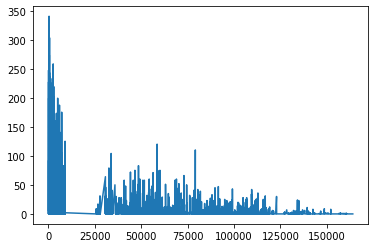

In [240]:
# how often a movie is rated
result = df_ratings.groupby(by='movieId')
data = result.size()
plt.plot(data)

### Hoe vaak een specifieke rating is gegeven.

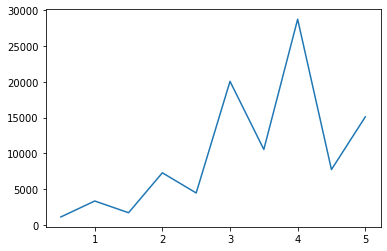

In [241]:
# how often a specific ratings is given
result = df_ratings.groupby(by='rating')
data = result.size()
plt.plot(data)

### Verdeeldheid van de gemiddelde beoordeling van een film.

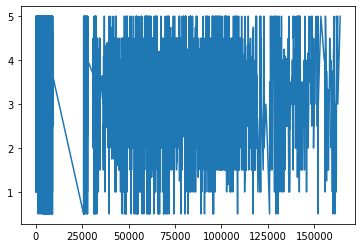

In [242]:
# Distribution of the average ratings given to a movie
result = df_ratings.groupby(by='movieId').agg({'rating' : 'mean'})
plt.plot(result)

### Verdeeldheid van de gemiddelde beoordeling gegeven door een gebruiker

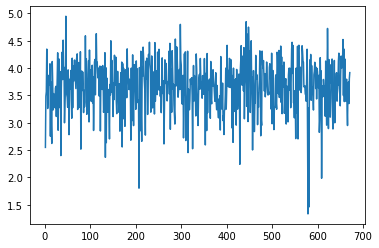

In [243]:
# Distribution of the average ratings given by a user
result = df_ratings.groupby(by='userId').agg({'rating' : 'mean'})
plt.plot(result)

## Dataset analysis

Voordat we verder gaan zullen we een analyse uitvoeren op de movie dataset.

In [244]:
df_ratings.describe(include="all")

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


De minimale rating is een 0.5 en de maximale rating is een 5.0. Er lijken dus geen rare outliers te zijn die buiten de 0.5 - 5.0 range zitten.

In [245]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Op dit moment lijken er geen problemen te zijn met de dataset van de ratings

In [246]:
df_movies.describe(include="all")

,movieId,title,genres
count,9125.000000,9125,9125
unique,NaN,9123,902
top,NaN,Hamlet (2000),Drama
freq,NaN,2,1170
mean,31123.291836,NaN,NaN
std,40782.633604,NaN,NaN
min,1.000000,NaN,NaN
25%,2850.000000,NaN,NaN
50%,6290.000000,NaN,NaN
75%,56274.000000,NaN,NaN


Kijkend naar de resultaten, lijkt het erop dat er een duplicatie zit in film titels. Deze duplicatie zullen we verwijderen. De duplicatie van genre kunnen we negeren, omdat het logisch is omdat er films bestaan die dezelfde genres hebben.

In [247]:
# there seems to be some duplicates on the titel.
df_movies.drop_duplicates(subset='title', inplace=True)
#duplicates removed.

De duplicaten zijn verwijderd. Verder lijken er ook geen null waardes te zijn. Dus kunnen we verder met het samenvoegen van de data tot 1 matrix

In [248]:
ratings = df_ratings
movies = df_movies

ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


De ratings dataset bevat een movieId. De MovieId kan gebruikt worden om de ratings dataset te mergen met de movie dataset.

In [249]:
df_test = pd.merge(ratings, movies, on='movieId', how='left')
df_test
df_test.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
5,1,1263,2.0,1260759151,"Deer Hunter, The (1978)",Drama|War
6,1,1287,2.0,1260759187,Ben-Hur (1959),Action|Adventure|Drama
7,1,1293,2.0,1260759148,Gandhi (1982),Drama
8,1,1339,3.5,1260759125,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller
9,1,1343,2.0,1260759131,Cape Fear (1991),Thriller


Zoals het hierboven te zien is, zijn de twee datasets samengevoegd. Nu zullen we verder gaan met het analyseren van de data.

### Gemiddelde beoordeling van een film

In [250]:
average_ratings = pd.DataFrame(df_test.groupby('movieId')['rating'].mean())
average_ratings.head(10)

,rating
movieId,
1,3.872470
2,3.401869
3,3.161017
4,2.384615
5,3.267857
6,3.884615
7,3.283019
8,3.800000
9,3.150000


### Totaal aantal beoordelingen van een film

In [251]:
average_ratings['Total Ratings'] = pd.DataFrame(df_test.groupby('movieId')['rating'].count())
average_ratings.head(10)

,rating,Total Ratings
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56
6,3.884615,104
7,3.283019,53
8,3.800000,5
9,3.150000,20


Na het analyseren zullen we nu verder gaan met het toepassen van Collaborative Filtering. Allereerst zullen we bezig gaan met een Movie -> User matrix.

## Movie -> User matrix

Items die niet beoordeeld zijn door een gebruiker zullen gevuld worden met 0. De reden hiervoor is dat de cosine similarity functie niet om kan gaan met NaN waardes.

In [252]:
movie_user = df_test.pivot_table(index='userId', columns='movieId', values='rating')
movie_user.head(10)
movie_user = movie_user.fillna(0)
movie_user

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Voor ieder Recommendation onderdeel zullen we de volgende Similarity Metrics gebruiken:

- Cosine Similarity
- Pearson Similarity
- Adjusted Cosine Similarity

Hieronder zullen we ieder metric definieren en testen door middel van een voorbeeld dataset. 

De voorbeeld dataset ziet er als volgt uit met een x aantal films en 3 gebruikers(0, 1, 2).

In [253]:
test_example_array = [[4,0,0,5,1,0,0],[5,5,4,0,0,0,0],[0,0,0,2,4,5,0]]
test_example_df = pd.DataFrame(data=test_example_array)
test_example_df

,0,1,2,3,4,5,6
0,4,0,0,5,1,0,0
1,5,5,4,0,0,0,0
2,0,0,0,2,4,5,0


### Cosine Similarity

Hieronder zullen we de Cosine similarity functie definieren.

In [254]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_metric(input_df, amount_of_users):
    print('---start cosine---')
    user_user = pd.DataFrame(index = input_df.index, columns = input_df.index)
    
    for i in input_df.index:
        userA = input_df.loc[i]
    
        for ii in input_df.index:
            userB = input_df.loc[ii]
            similarity = 0
            similarity = cosine_similarity(userA.to_numpy().reshape(1, -1), userB.to_numpy().reshape(1, -1))
            user_user.at[i, ii] = similarity[0][0]
        print('user: ', i, ' is done.')
    print('---cosine done---')    
    return user_user

Om de metric te testen hebben we een kleine dataset aangemaakt met 3 gebruikers en de bijbehorende beoordelingen. Op deze dataset willen we de hierboven gedefinieerde cosine metric op toepassen. 

#### Test cosine similarity with dataset

In [255]:
results_cosine_similarity_test = cosine_similarity_metric(test_example_df, len(test_example_df))
results_cosine_similarity_test

---start cosine---
user:  0  is done.
user:  1  is done.
user:  2  is done.
---cosine done---


,0,1,2
0,1.0,0.379869,0.322031
1,0.379869,1.0,0.0
2,0.322031,0.0,1.0


We hebben nu de cosine similarity metric op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de cosine similarity tussen de gebruikers weer. Hoe meer de waarde dichter bij de 1 des te meer overeenkomsten er zijn. Hoe meer de waarde bij de 0, des te minder dus.

Na het toepassen van de metric zien we de resultaten hierboven. Daaruit kunnen we de volgende conclusies trekken:

- Gebruiker 0 -> gebruiker 1 hebben een similarity van 0.38 afgerond.
- gebruiker 0 -> gebruiker 2 hebben een similarity van 0.32 afgerond.
- gebruiker 1 -> gebruiker 2 hebben een similarity van 0.00.
- gebruiker 0 -> gebruiker 1 hebben meer overeenkomsten samen dan gebruiker 0 -> gebruiker 2 en gebruiker 1 -> gebruiker 2

Nu zullen we zelf de similarity metric met de hand berekenen. De formule hiervoor is 

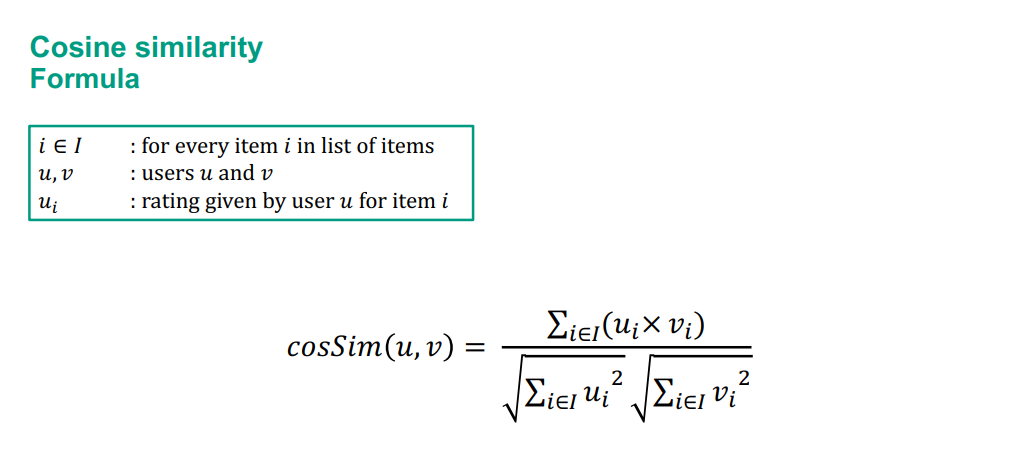

#### Test 1
Dit betekent voor het berekenem van de similarity tussen gebruiker 0 en 1 het volgende:

Cosine similarity(0, 1) = <br>
(4x5+0x5+0x4+5x0+1x0+0x0+0x0) / √(4²+0+0+5²+1²+0+0) x √(5²+5²+4²+0+0+0+0) = <br>
20 / (√42 x √66) = <br>
20 / 52,65 = <br>
0.38 

#### Test 2
Dit betekent voor het berekenem van de similarity tussen gebruiker 0 en 2 het volgende:

Cosine similarity(0, 2) = <br>
(4x0+0x0+0x0+5x2+1x4+0x5+0x0) / √(4²+0+0+5²+1²+0+0) x √(0+0+0+2²+4²+5²+0) = <br>
14 / (√42 x √45) = <br>
14 / 43.47 = <br>
0.32

De resultaten uit de testen komen overeen met de resultaten uit de gedefinieerde metric. Dit betekent dat de gedefinieerde cosine similarity metric goed lijkt te werken.

### Pearson similarity

Hieronder zullen we de Pearson similarity functie definieren.

In [256]:
def getAverage(row):
    total = row.sum()
    ratedMovies = 0
    for i in range(0, len(row) - 1):
        if row.iloc[i] > 0:
            ratedMovies = ratedMovies + 1
    
    if ratedMovies == 0:
        return 0
    return total/ratedMovies

def pearson(row):
    for i in row.index:
        if row[i] > 0 and i != 'mean':
            row[i] = row[i] - row['mean']
    return row

def pearson_similarity_metric(input_df):
    input_df_copy = input_df.copy(deep=True)
    input_df_copy['mean'] = input_df_copy.apply(lambda row : getAverage(row), axis=1)
    input_df_copy = input_df_copy.apply(lambda row : pearson(row), axis=1)
    return input_df_copy

def pearson_cosine_similarity_metric(input_df):
    print('---start pearson metric---')
    result_pearson_metric = pearson_similarity_metric(input_df)
    print('---normalizing done---')
    result_pearson_metric.drop('mean', inplace=True, axis=1)
    result_cosine_similarity = cosine_similarity_metric(result_pearson_metric, len(result_pearson_metric))
    print('---pearson metric done---')
    return result_cosine_similarity

Om de metric te testen hebben we een kleine dataset aangemaakt met 3 gebruikers en de bijbehorende beoordelingen. Op deze dataset willen we de hierboven gedefinieerde pearson metric op toepassen. 

### Test pearson similarity with dataset

Allereerst zullen we testen of de functie voor het normalizeren van de vectors werkt. Het normalizeren van de vectors zorgt ervoor dat de ratings rond 0 zijn gecentreerd.

#### Test normalisatie vectors

In [257]:
result_pearson_similarity_metric_test = pearson_similarity_metric(test_example_df)
result_pearson_similarity_metric_test

,0,1,2,3,4,5,6,mean
0,0.666667,0.000000,0.000000,1.666667,-2.333333,0.000000,0.0,3.333333
1,0.333333,0.333333,-0.666667,0.000000,0.000000,0.000000,0.0,4.666667
2,0.000000,0.000000,0.000000,-1.666667,0.333333,1.333333,0.0,3.666667


We hebben nu het normaliseren van de vectors op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de ratings genormaliseerd weer. positieve waardes representeren positieve ratings en negatiefe waardes representeren negatieve ratings.

Nu zullen we de normalisatie met de hand berekenen

#### Test 1

Hiervoor zullen we eerst de gemiddelde rating berekenen van gebruiker 0.

Gem van gebruiker 0 = <br>
(4 + 5 + 1) / 3 = <br>
10 / 3

Na het berekenen van de gemiddelde zullen we de gemiddelde aftrekken van de ratings. <br>
4 - 10/3 = 2/3 <br>
5 - 10/3 = 5/3 <br>
1 - 10/3 = -7/3

Dit levert de volgende lijst van ratings op voor gebruiker 0:

[2/3, 0, 0, 5/3, -7/3, 0, 0]

#### Test 2

Hiervoor zullen we eerst de gemiddelde rating berekenen van gebruiker 1.

Gem van gebruiker 0 = <br>
(5 + 5 + 4) / 3 = <br>
14 / 3

Na het berekenen van de gemiddelde zullen we de gemiddelde aftrekken van de ratings. <br>
5 - 14/3 = 1/3 <br>
5 - 14/3 = 1/3 <br>
4 - 14/3 = -2/3

Dit levert de volgende lijst van ratings op voor gebruiker 0:

[1/3, 1/3, -2/3, 0, 0, 0, 0]

#### Conclusie
De resultaten van beide tests komen overeen met de resultaten van de functies. hieruit kunnen we concluderen dat het normaliseren van de vectors werkt.

### Test Pearson correlation metric

In [258]:
result_pearson_cosine_similarity_test = pearson_cosine_similarity_metric(test_example_df)
result_pearson_cosine_similarity_test

---start pearson metric---
---normalizing done---
---start cosine---
user:  0  is done.
user:  1  is done.
user:  2  is done.
---cosine done---
---pearson metric done---


,0,1,2
0,1.0,0.09245,-0.559085
1,0.09245,1.0,0.0
2,-0.559085,0.0,1.0


We hebben nu pearson similarity metric op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de cosine similarity tussen de gebruikers weer. Hoe meer de waarde dichter bij de 1 des te meer overeenkomsten er zijn. Hoe meer de waarde bij de 0, des te minder dus.

Na het toepassen van de metric zien we de resultaten hierboven. Daaruit kunnen we de volgende conclusies trekken:

- Gebruiker 0 -> gebruiker 1 hebben een similarity van 0.38 afgerond.
- gebruiker 0 -> gebruiker 2 hebben een similarity van 0.32 afgerond.
- gebruiker 0 -> gebruiker 1 hebben een similarity van 0.00.
- gebruiker 0 -> gebruiker 1 hebben meer overeenkomsten samen dan gebruiker 0 -> gebruiker 2 en - - gebruiker 1 -> gebruiker 2

Nu zullen we zelf de similarity metric met de hand berekenen. De formule hiervoor is

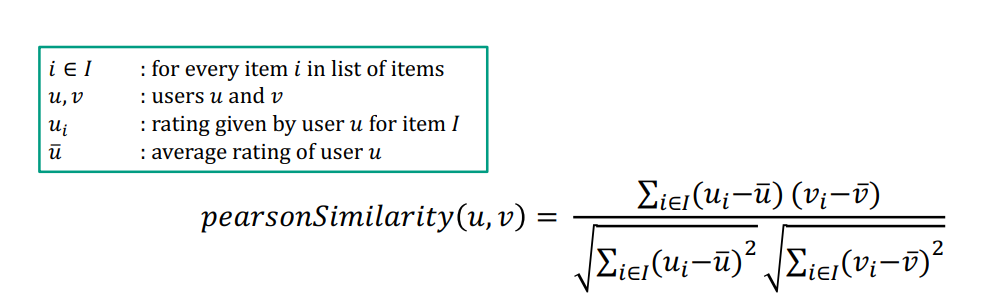

#### Test 1

Hiervoor zullen we de lijst die in Test 1 en 2 zijn berekend gebruiken.

genormaliseerde ratings gebruiker 0 = [2/3, 0, 0, 5/3, -7/3, 0, 0]
genormaliseerde ratings gebruiker 1 = [1/3, 1/3, -2/3, 0, 0, 0, 0]

Dit betekent voor het berekenem van de similarity tussen gebruiker 0 en 1 het volgende:



Pearson Similarity(0,1) =

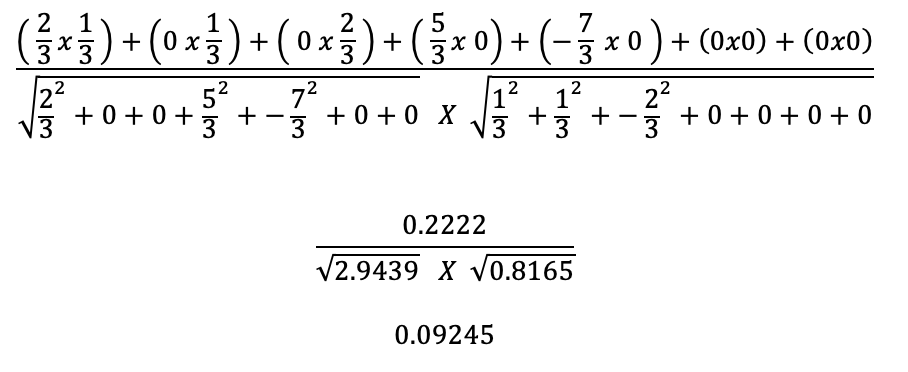

De resultaat uit de test komen overeen met de resultaat uit de gedefinieerde metric. Dit betekent dat de gedefinieerde pearson similarity metric goed lijkt te werken.


#### Conclusie
Het resultaat van de test komt overeen met de resultaten van de functies. hieruit kunnen we concluderen dat de gedefinieerde pearson similarity metric werkt.

## Adjusted Cosine similarity

Hieronder zullen we de Adjusted Sosine similarity functie definieren.

In [259]:
def getAverageColumn(col):
    total = col.sum()

    ratedMovies = 0
    for i in range(0, len(col)):
        if col.iloc[i] > 0:
            ratedMovies = ratedMovies + 1
    
    if ratedMovies == 0:
        return 0
    return total/ratedMovies

def adjusted_cosine_normalizing(col):
    for i in col.index:
        if col[i] > 0 and i != 'mean':
            col[i] = col[i] - col['mean']
    return col

def adjustud_cosine_metric(input_df):
    input_df_copy = input_df.copy(deep=True)
    mean_row = input_df_copy.apply(lambda col : getAverageColumn(col))
    mean_df = pd.DataFrame([mean_row], index = ["mean"])
    input_df_with_mean = pd.concat([mean_df, input_df_copy])
    input_df_with_mean = input_df_with_mean.apply(lambda col : adjusted_cosine_normalizing(col))
    return input_df_with_mean

def adjusted_cosine_similarity_metric(input_df):
    print('---start adjusted cosine metric---')
    result_adjusted_cosine_metric = adjustud_cosine_metric(input_df)
    print('---normalizing done---')
    result_adjusted_cosine_metric.drop('mean', inplace=True)
    result_adjusted_cosine_similarity = cosine_similarity_metric(result_adjusted_cosine_metric, len(result_adjusted_cosine_metric))
    print('---adjusted cosine metric done---')
    return result_adjusted_cosine_similarity

test_example_array2 = [[4,0,0,5,1,0,0],[5,5,4,0,0,0,0],[0,0,0,2,4,5,0],[0,3,0,0,0,0,3]]
test_example_df2 = pd.DataFrame(data=test_example_array2)
test_example_df2

,0,1,2,3,4,5,6
0,4,0,0,5,1,0,0
1,5,5,4,0,0,0,0
2,0,0,0,2,4,5,0
3,0,3,0,0,0,0,3


Om de metric te testen hebben we een kleine dataset aangemaakt met 4 gebruikers en de bijbehorende beoordelingen. Op deze dataset willen we de hierboven gedefinieerde adjusted cosine similarity metric op toepassen. 

### Test adjusted cosine similarity with dataset

Allereerst zullen we testen of de functie voor het normaliseren van de vectors werkt. Het normaliseren van de vectors zorgt ervoor dat de ratings rond 0 zijn gecentreerd.

#### Test normalisatie vectors

In [260]:
result_cosine_metric = adjustud_cosine_metric(test_example_df2)
result_cosine_metric

,0,1,2,3,4,5,6
mean,4.5,4.0,4.0,3.5,2.5,5.0,3.0
0,-0.5,0.0,0.0,1.5,-1.5,0.0,0.0
1,0.5,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,-1.5,1.5,0.0,0.0
3,0.0,-1.0,0.0,0.0,0.0,0.0,0.0


We hebben nu het normaliseren van de vectors op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de ratings genormaliseerd weer. positieve waardes representeren positieve ratings en negatiefe waardes representeren negatieve ratings.

Nu zullen we de normalisatie met de hand berekenen

#### Test 1

Hiervoor zullen we eerst de gemiddelde rating berekenen van film 0.

Gem van film 0 = <br>
(4 + 5) / 2 = <br>
9 / 2 = <br>
4.5

Na het berekenen van de gemiddelde zullen we de gemiddelde aftrekken van de ratings.
4 - 4.5 = -0.5
5 - 4.5 = 0.5

Dit levert de volgende lijst van ratings op voor film 0:

[-0.5, 0.5, 0, 0]

#### Test 2

Hiervoor zullen we eerst de gemiddelde rating berekenen van film 1.

Gem van gebruiker 0 = <br>
(5 + 3) / 2 = <br>
8 / 2 = <br>
4

Na het berekenen van de gemiddelde zullen we de gemiddelde aftrekken van de ratings.
5 - 4 = 1
3 - 4 = -1

Dit levert de volgende lijst van ratings op voor film 1:

[0, 1, 0, -1]

#### Conclusie
De resultaten van beide tests komen overeen met de resultaten van de gedefinieerde functies. hieruit kunnen we concluderen dat het normaliseren van de vectors werkt.

### Test adjsuted cosine similarity metric

In [261]:
result_adjusted_cosine_similarity = adjusted_cosine_similarity_metric(test_example_df2)
result_adjusted_cosine_similarity

---start adjusted cosine metric---
---normalizing done---
---start cosine---
user:  0  is done.
user:  1  is done.
user:  2  is done.
user:  3  is done.
---cosine done---
---adjusted cosine metric done---


,0,1,2,3
0,1.0,-0.102598,-0.973329,0.0
1,-0.102598,1.0,0.0,-0.894427
2,-0.973329,0.0,1.0,0.0
3,0.0,-0.894427,0.0,1.0


We hebben nu de adjusted cosine similarity metric op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de cosine similarity tussen de gebruikers weer. Hoe meer de waarde dichter bij de 1 des te meer overeenkomsten er zijn. Hoe meer de waarde bij de -1, des te minder dus.

Na het toepassen van de metric zien we de resultaten hierboven. Daaruit kunnen we de volgende conclusies trekken:

- Gebruiker 0 -> gebruiker 1 hebben een similarity van 0.38 afgerond.
- gebruiker 0 -> gebruiker 2 hebben een similarity van 0.32 afgerond.
- gebruiker 0 -> gebruiker 1 hebben een similarity van 0.00.
- gebruiker 0 -> gebruiker 1 hebben meer overeenkomsten samen dan gebruiker 0 -> gebruiker 2 en - - gebruiker 1 -> gebruiker 2

Nu zullen we zelf de similarity metric met de hand berekenen. De formule hiervoor is

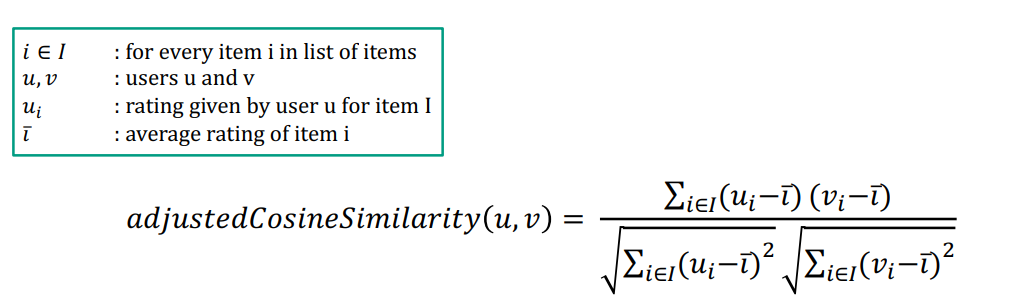

#### Test 1

Hiervoor zullen we eerst de gemiddelde rating berekenen per film en dit aftrekken van de rating van de gebruiker voor die film. Daaruit onstaat de volgende lijst 

genormaliseerde ratings gebruiker 0 = [-0.5, 0, 0, 3/2, -3/2, 0, 0] <br>
genormaliseerde ratings gebruiker 1 = [0.5, 1, 0, 0, 0, 0, 0] <br>
genormaliseerde ratings gebruiker 2 = [0, 0, 0, -3/2, 3/2, 0, 0] <br>
genormaliseerde ratings gebruiker 3 = [0, -1, 0, 0, 0, 0, 0]

Dit betekent voor het berekenen van de similarity tussen gebruiker 0 en 1 het volgende:



Adjusted Cosine Similarity(0,1) =

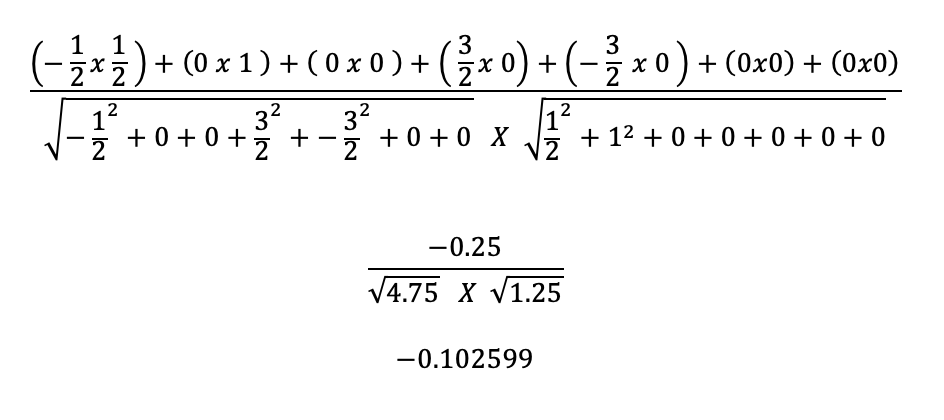

De resultaat uit de test komen overeen met de resultaat uit de gedefinieerde metric. Dit betekent dat de gedefinieerde adjusted cosine similarity metric goed lijkt te werken.


#### Conclusie
Het resultaat van de test komt overeen met de resultaten van de functies. hieruit kunnen we concluderen dat de gedefinieerde adjusted cosine similarity metric werkt.


Nu we voor ieder similarity metric een implementatie hebben geschreven en dit ook hebben getest/gevalideerd door middel van een voorbeeld kunnen we werder met het implementeren van de recommendation systems

Voor het opdracht zal er een User-User en Item-Item recommendation systeem gemaakt worden.

## User-user recommendation

In dit hoofdstuk zal de user-item matrix omgezet worden naar een user-user similarity matrix. Dit zal gebeuren door middel van de similarity metrics die we in de vorige hoofdstuk hebben gedefinieerd. De user-user similarity matrix zal gebruikt worden worden voor het implementeren van de user-user recommendation algoritm.

Allereerst zullen we voor ieder similarity metric een user-user similarity matrix maken. Dit inv verband met performance. Zo hoeft de similarity matrix niet telkens opnieuw berekend te worden.

In [262]:
movie_user1 = movie_user.copy(deep=True)
user_user_cosine = cosine_similarity_metric(movie_user1, len(movie_user1))
user_user_pearson = pearson_cosine_similarity_metric(movie_user1)
user_user_adjusted_cosine = adjusted_cosine_similarity_metric(movie_user1)

---start cosine---
user:  1  is done.
user:  2  is done.
user:  3  is done.
user:  4  is done.
user:  5  is done.
user:  6  is done.
user:  7  is done.
user:  8  is done.
user:  9  is done.
user:  10  is done.
user:  11  is done.
user:  12  is done.
user:  13  is done.
user:  14  is done.
user:  15  is done.
user:  16  is done.
user:  17  is done.
user:  18  is done.
user:  19  is done.
user:  20  is done.
user:  21  is done.
user:  22  is done.
user:  23  is done.
user:  24  is done.
user:  25  is done.
user:  26  is done.
user:  27  is done.
user:  28  is done.
user:  29  is done.
user:  30  is done.
user:  31  is done.
user:  32  is done.
user:  33  is done.
user:  34  is done.
user:  35  is done.
user:  36  is done.
user:  37  is done.
user:  38  is done.
user:  39  is done.
user:  40  is done.
user:  41  is done.
user:  42  is done.
user:  43  is done.
user:  44  is done.
user:  45  is done.
user:  46  is done.
user:  47  is done.
user:  48  is done.
user:  49  is done.
user:  50 

user:  396  is done.
user:  397  is done.
user:  398  is done.
user:  399  is done.
user:  400  is done.
user:  401  is done.
user:  402  is done.
user:  403  is done.
user:  404  is done.
user:  405  is done.
user:  406  is done.
user:  407  is done.
user:  408  is done.
user:  409  is done.
user:  410  is done.
user:  411  is done.
user:  412  is done.
user:  413  is done.
user:  414  is done.
user:  415  is done.
user:  416  is done.
user:  417  is done.
user:  418  is done.
user:  419  is done.
user:  420  is done.
user:  421  is done.
user:  422  is done.
user:  423  is done.
user:  424  is done.
user:  425  is done.
user:  426  is done.
user:  427  is done.
user:  428  is done.
user:  429  is done.
user:  430  is done.
user:  431  is done.
user:  432  is done.
user:  433  is done.
user:  434  is done.
user:  435  is done.
user:  436  is done.
user:  437  is done.
user:  438  is done.
user:  439  is done.
user:  440  is done.
user:  441  is done.
user:  442  is done.
user:  443  i

user:  117  is done.
user:  118  is done.
user:  119  is done.
user:  120  is done.
user:  121  is done.
user:  122  is done.
user:  123  is done.
user:  124  is done.
user:  125  is done.
user:  126  is done.
user:  127  is done.
user:  128  is done.
user:  129  is done.
user:  130  is done.
user:  131  is done.
user:  132  is done.
user:  133  is done.
user:  134  is done.
user:  135  is done.
user:  136  is done.
user:  137  is done.
user:  138  is done.
user:  139  is done.
user:  140  is done.
user:  141  is done.
user:  142  is done.
user:  143  is done.
user:  144  is done.
user:  145  is done.
user:  146  is done.
user:  147  is done.
user:  148  is done.
user:  149  is done.
user:  150  is done.
user:  151  is done.
user:  152  is done.
user:  153  is done.
user:  154  is done.
user:  155  is done.
user:  156  is done.
user:  157  is done.
user:  158  is done.
user:  159  is done.
user:  160  is done.
user:  161  is done.
user:  162  is done.
user:  163  is done.
user:  164  i

user:  508  is done.
user:  509  is done.
user:  510  is done.
user:  511  is done.
user:  512  is done.
user:  513  is done.
user:  514  is done.
user:  515  is done.
user:  516  is done.
user:  517  is done.
user:  518  is done.
user:  519  is done.
user:  520  is done.
user:  521  is done.
user:  522  is done.
user:  523  is done.
user:  524  is done.
user:  525  is done.
user:  526  is done.
user:  527  is done.
user:  528  is done.
user:  529  is done.
user:  530  is done.
user:  531  is done.
user:  532  is done.
user:  533  is done.
user:  534  is done.
user:  535  is done.
user:  536  is done.
user:  537  is done.
user:  538  is done.
user:  539  is done.
user:  540  is done.
user:  541  is done.
user:  542  is done.
user:  543  is done.
user:  544  is done.
user:  545  is done.
user:  546  is done.
user:  547  is done.
user:  548  is done.
user:  549  is done.
user:  550  is done.
user:  551  is done.
user:  552  is done.
user:  553  is done.
user:  554  is done.
user:  555  i

user:  227  is done.
user:  228  is done.
user:  229  is done.
user:  230  is done.
user:  231  is done.
user:  232  is done.
user:  233  is done.
user:  234  is done.
user:  235  is done.
user:  236  is done.
user:  237  is done.
user:  238  is done.
user:  239  is done.
user:  240  is done.
user:  241  is done.
user:  242  is done.
user:  243  is done.
user:  244  is done.
user:  245  is done.
user:  246  is done.
user:  247  is done.
user:  248  is done.
user:  249  is done.
user:  250  is done.
user:  251  is done.
user:  252  is done.
user:  253  is done.
user:  254  is done.
user:  255  is done.
user:  256  is done.
user:  257  is done.
user:  258  is done.
user:  259  is done.
user:  260  is done.
user:  261  is done.
user:  262  is done.
user:  263  is done.
user:  264  is done.
user:  265  is done.
user:  266  is done.
user:  267  is done.
user:  268  is done.
user:  269  is done.
user:  270  is done.
user:  271  is done.
user:  272  is done.
user:  273  is done.
user:  274  i

user:  618  is done.
user:  619  is done.
user:  620  is done.
user:  621  is done.
user:  622  is done.
user:  623  is done.
user:  624  is done.
user:  625  is done.
user:  626  is done.
user:  627  is done.
user:  628  is done.
user:  629  is done.
user:  630  is done.
user:  631  is done.
user:  632  is done.
user:  633  is done.
user:  634  is done.
user:  635  is done.
user:  636  is done.
user:  637  is done.
user:  638  is done.
user:  639  is done.
user:  640  is done.
user:  641  is done.
user:  642  is done.
user:  643  is done.
user:  644  is done.
user:  645  is done.
user:  646  is done.
user:  647  is done.
user:  648  is done.
user:  649  is done.
user:  650  is done.
user:  651  is done.
user:  652  is done.
user:  653  is done.
user:  654  is done.
user:  655  is done.
user:  656  is done.
user:  657  is done.
user:  658  is done.
user:  659  is done.
user:  660  is done.
user:  661  is done.
user:  662  is done.
user:  663  is done.
user:  664  is done.
user:  665  i

Voor ieder similarity metric bestaat er nu een similarity matrix. Deze matrices kunnen we gebruiken voor het vinden van overeenkomende gebruikers. Nu zullen we verder gaan met het implementeren van de user-user recommendation algoritme

In [263]:
from IPython.core.display import HTML
from movie_display import movie_display
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Allereerst zullen we ervoor moeten zorgen dat het mogelijk is om een input systeem te maken. Met deze input systeem is het mogelijk om het aantal aanbevolen, de gebruiker en de type similarity metric te kunnen kiezen.

#### N aantal aanbevolen

In [453]:
n_recommendations = 5
given_user = 1
similarity_types = [('cosine', 0), ('pearson', 1), ('adjusted cosine', 2)]
selected_similarity_type = 0

def select_n_recommendations(recommendations):
    global n_recommendations
    n_recommendations = recommendations
    print('selected number: ', n_recommendations)
    
def select_user(user):
    global given_user
    given_user = user
    print('selected user: ', given_user)
    
def select_similarity_and_run(similarity):
    global selected_similarity_type
    global user_user_similarity
    global movie_user_testje
    selected_similarity_type = similarity
    if similarity == 0:
        print('cosine chosen')
        #user_user_similarity = cosine_similarity_metric(movie_user_testje, len(movie_user_testje))
        getRecommendedMovies(user_user_cosine)
    elif similarity == 1:
        print('pearson chosen')
        #user_user_similarity = pearson_cosine_similarity_metric(movie_user_testje)
        getRecommendedMovies(user_user_pearson)
    elif similarity == 2:
        print('adjusted cosine chosen')
        #user_user_similarity = adjusted_cosine_similarity_metric(movie_user_testje)
        getRecommendedMovies(user_user_adjusted_cosine)
        
movie_user1 = movie_user.copy(deep=True)

def weighted_sum(col, most_similar_users):
    for i in col.index:
        col[i] = col[i] * most_similar_users[i]
        
    return col

result_user_user = pd.DataFrame()
def getRecommendedMovies(similarity_matrix):
    global n_recommendations
    global given_user
    global result_user_user
    
    # 11 meest overeenkomende gebruikers worden geselecteerd.
    most_similar_users = similarity_matrix.loc[given_user].sort_values(ascending=False).head(11)
    
    # Geselecteerde gebruiker zit in lijst. Die wordt eruit gehaald
    most_similar_users = most_similar_users.drop(axis='index', labels=[given_user])
    most_similar_users_matrix = movie_user1.loc[most_similar_users.index]
    
    # Score candidates weighted sum
    most_similar_users_matrix = most_similar_users_matrix.apply(lambda row : weighted_sum(row, most_similar_users)) 
    all_results = pd.DataFrame()
    for i in most_similar_users.index:
        tmp_result = pd.DataFrame({'movieId' : most_similar_users_matrix.columns, 
                                   'scored' : most_similar_users_matrix.loc[i].to_numpy()})
        all_results = all_results.append(tmp_result)
        
    sorted_list = all_results.sort_values('scored', ascending=False).drop_duplicates(subset='movieId', keep='first')
    result_user_user = sorted_list.head(n_recommendations)
    

In [305]:
interact(select_n_recommendations, recommendations=widgets.IntSlider(min=1, max=10, step=1, value=n_recommendations))  
interact(select_user, user=widgets.IntSlider(min=1, max=100, step=1, value=given_user))
interact_manual(select_similarity_and_run, similarity=similarity_types)

interactive(children=(IntSlider(value=5, description='recommendations', max=10, min=1), Output()), _dom_classe…

interactive(children=(IntSlider(value=1, description='user', min=1), Output()), _dom_classes=('widget-interact…

interactive(children=(Dropdown(description='similarity', options=(('cosine', 0), ('pearson', 1), ('adjusted co…

<function __main__.select_similarity_and_run(similarity)>

Na het uitvoeren van de bovenstaande commando's, zal het resultaat in de volgende regel geprint kunnen worden

In [306]:
result_user_user

,movieId,scored
3268,4085,1.673332
30,31,1.673332
518,585,1.487406
1247,1569,1.487406
859,1061,1.301481


## Item-item recommendation

In dit hoofdstuk zal de user-item matrix omgezet worden naar een item-item similarity matrix. Dit zal gebeuren door middel van de similarity metrics die we in de vorige hoofdstuk hebben gedefinieerd. De item-item similarity matrix zal gebruikt worden worden voor het implementeren van de item-item recommendation algoritm.

Allereerst zullen we voor ieder similarity metric een user-user similarity matrix maken. Dit inv verband met performance. Zo hoeft de similarity matrix niet telkens opnieuw berekend te worden.

In [329]:
movie_user2 = df_test.pivot_table(index='movieId', columns='userId', values='rating')
movie_user2 = movie_user2.dropna(axis=1, how='all')
movie_user2 = movie_user2.fillna(0)
movie_user2

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [333]:
shorted_movie_user = movie_user2.head(500)


item_item_cosine = cosine_similarity_metric(shorted_movie_user, len(shorted_movie_user))
item_item_pearson = pearson_cosine_similarity_metric(shorted_movie_user)
item_item_adjusted_cosine = adjusted_cosine_similarity_metric(shorted_movie_user)

---start cosine---
user:  1  is done.
user:  2  is done.
user:  3  is done.
user:  4  is done.
user:  5  is done.
user:  6  is done.
user:  7  is done.
user:  8  is done.
user:  9  is done.
user:  10  is done.
user:  11  is done.
user:  12  is done.
user:  13  is done.
user:  14  is done.
user:  15  is done.
user:  16  is done.
user:  17  is done.
user:  18  is done.
user:  19  is done.
user:  20  is done.
user:  21  is done.
user:  22  is done.
user:  23  is done.
user:  24  is done.
user:  25  is done.
user:  26  is done.
user:  27  is done.
user:  28  is done.
user:  29  is done.
user:  30  is done.
user:  31  is done.
user:  32  is done.
user:  34  is done.
user:  35  is done.
user:  36  is done.
user:  37  is done.
user:  38  is done.
user:  39  is done.
user:  40  is done.
user:  41  is done.
user:  42  is done.
user:  43  is done.
user:  44  is done.
user:  45  is done.
user:  46  is done.
user:  47  is done.
user:  48  is done.
user:  49  is done.
user:  50  is done.
user:  52 

user:  446  is done.
user:  447  is done.
user:  448  is done.
user:  449  is done.
user:  450  is done.
user:  451  is done.
user:  452  is done.
user:  453  is done.
user:  454  is done.
user:  455  is done.
user:  456  is done.
user:  457  is done.
user:  458  is done.
user:  459  is done.
user:  460  is done.
user:  461  is done.
user:  463  is done.
user:  464  is done.
user:  465  is done.
user:  466  is done.
user:  467  is done.
user:  468  is done.
user:  469  is done.
user:  470  is done.
user:  471  is done.
user:  472  is done.
user:  473  is done.
user:  474  is done.
user:  475  is done.
user:  476  is done.
user:  477  is done.
user:  479  is done.
user:  480  is done.
user:  481  is done.
user:  482  is done.
user:  483  is done.
user:  484  is done.
user:  485  is done.
user:  486  is done.
user:  487  is done.
user:  488  is done.
user:  489  is done.
user:  490  is done.
user:  491  is done.
user:  492  is done.
user:  493  is done.
user:  494  is done.
user:  495  i

user:  320  is done.
user:  321  is done.
user:  322  is done.
user:  324  is done.
user:  325  is done.
user:  326  is done.
user:  327  is done.
user:  328  is done.
user:  329  is done.
user:  330  is done.
user:  331  is done.
user:  332  is done.
user:  333  is done.
user:  334  is done.
user:  335  is done.
user:  336  is done.
user:  337  is done.
user:  338  is done.
user:  339  is done.
user:  340  is done.
user:  341  is done.
user:  342  is done.
user:  343  is done.
user:  344  is done.
user:  345  is done.
user:  346  is done.
user:  347  is done.
user:  348  is done.
user:  349  is done.
user:  350  is done.
user:  351  is done.
user:  352  is done.
user:  353  is done.
user:  354  is done.
user:  355  is done.
user:  356  is done.
user:  357  is done.
user:  358  is done.
user:  360  is done.
user:  361  is done.
user:  362  is done.
user:  363  is done.
user:  364  is done.
user:  365  is done.
user:  366  is done.
user:  367  is done.
user:  368  is done.
user:  369  i

user:  200  is done.
user:  201  is done.
user:  202  is done.
user:  203  is done.
user:  204  is done.
user:  205  is done.
user:  206  is done.
user:  207  is done.
user:  208  is done.
user:  209  is done.
user:  211  is done.
user:  213  is done.
user:  214  is done.
user:  215  is done.
user:  216  is done.
user:  217  is done.
user:  218  is done.
user:  219  is done.
user:  220  is done.
user:  222  is done.
user:  223  is done.
user:  224  is done.
user:  225  is done.
user:  227  is done.
user:  228  is done.
user:  229  is done.
user:  230  is done.
user:  231  is done.
user:  232  is done.
user:  233  is done.
user:  234  is done.
user:  235  is done.
user:  236  is done.
user:  237  is done.
user:  238  is done.
user:  239  is done.
user:  240  is done.
user:  241  is done.
user:  242  is done.
user:  243  is done.
user:  244  is done.
user:  245  is done.
user:  246  is done.
user:  247  is done.
user:  248  is done.
user:  249  is done.
user:  250  is done.
user:  251  i

In [499]:
n_recommendations2 = 5
given_user2 = 1
similarity_types = [('cosine', 0), ('pearson', 1), ('adjusted cosine', 2)]
selected_similarity_type2 = 0

def select_n_recommendations2(recommendations):
    global n_recommendations2
    n_recommendations2 = recommendations
    print('selected number: ', n_recommendations2)
    
def select_user2(user):
    global given_user2
    given_user2 = user
    print('selected user: ', given_user2)
    
def select_similarity_and_run2(similarity):
    if similarity == 0:
        print('cosine chosen')
        getRecommendedMovies2(item_item_cosine)
    elif similarity == 1:
        print('pearson chosen')
        getRecommendedMovies2(item_item_pearson)
    elif similarity == 2:
        print('adjusted cosine chosen')
        getRecommendedMovies2(item_item_adjusted_cosine)

def calculateRating(similar_ratings, similar_cosine):
    sumCosine = similar_cosine.sum()
    multiplication = (similar_ratings * similar_cosine).sum()
    if sumCosine == 0:
        return 0
    
    return round(multiplication / sumCosine, 2)


recommendations_item_item = pd.DataFrame()

def getRecommendedMovies2(similarity_matrix):
    global shorted_movie_user
    global given_user2
    global n_recommendations2
    global recommendations_item_item
    shorted_movie_user_copy = shorted_movie_user.copy(deep=True)
    
    liked_movies_index = shorted_movie_user_copy[shorted_movie_user_copy[given_user2] > 3.5].index
    not_rated_movies = shorted_movie_user_copy[shorted_movie_user_copy[given_user2] == 0]
    
    not_rated_movies_copy = not_rated_movies.copy(deep=True)
    
    for i in not_rated_movies.index:
        similar_item_to_movie_cosine = similarity_matrix.loc[i, liked_movies_index]
        similar_item_to_movie_rating = shorted_movie_user_copy.loc[i, liked_movies_index]
        not_rated_movies_copy.loc[i, given_user2] = calculateRating(similar_item_to_movie_rating, similar_item_to_movie_cosine)
        
    recommendations_item_item = not_rated_movies_c.loc[:, given_user2].nlargest(n_recommendations2)
  

In [413]:
interact(select_n_recommendations2, recommendations=widgets.IntSlider(min=1, max=10, step=1, value=n_recommendations))  
interact(select_user2, user=widgets.IntSlider(min=1, max=100, step=1, value=given_user))
interact_manual(select_similarity_and_run2, similarity=similarity_types)

interactive(children=(IntSlider(value=5, description='recommendations', max=10, min=1), Output()), _dom_classe…

interactive(children=(IntSlider(value=1, description='user', min=1), Output()), _dom_classes=('widget-interact…

interactive(children=(Dropdown(description='similarity', options=(('cosine', 0), ('pearson', 1), ('adjusted co…

<function __main__.select_similarity_and_run2(similarity)>

Na het uitvoeren van de bovenstaande commando's, kan het resultaat in de volgende cell uitgeprint worden.

In [ ]:
# print result
print(recommendations_item_item)

# Validation

In dit hoofdstuk zullen we zowel de user-user en item-item algoritme valideren. Allereerst zullen we dit doen door middel van de Hit Rate methode. Hierbij is het idee om een hoge rating per gebruiker uit de dataset halen. Deze rating zal in een test set bewaard worden. Daarna zullen we de recommendations ophalen per gebruiker. Als de film die eruit is gehaald er tussen in zit, dan is dit een positieve score. 

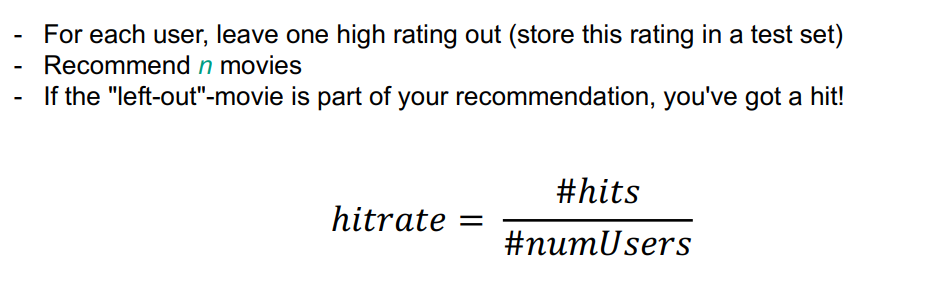

### User-user

In verband met de performance van mijn eigen systeem is het aantal geselecteerde items verlaagd. Dit kan aangepast worden door de onderstaande variabel aan te passen.

In [512]:
selected_users = 10
movie_user_validation = movie_user.copy(deep=True)
movie_user_validation = movie_user_validation.head(selected_users)
movie_user_validation_filtered = movie_user_validation.copy(deep=True)

Omdat het berekenen van de similarity matrix aardig wat tijd kost, kort ik de dataset in.

allereerst zullen we per gebruiker een rating eruit filteren.

In [513]:
test_set = pd.DataFrame()
        
for i in movie_user_validation.index:
    test_rating = movie_user_validation.loc[i].nlargest(1)
    tmp_result = pd.DataFrame({'movieId' : test_rating.index, 
                               'rating' : test_rating.iloc[0]}, index=[i])
    test_set = test_set.append(tmp_result)
    movie_user_validation_filtered.loc[i, test_rating.index] = 0
    
validation_user_user_adjusted_cosine = adjusted_cosine_similarity_metric(movie_user_validation_filtered)

---start adjusted cosine metric---
---normalizing done---
---start cosine---
user:  1  is done.
user:  2  is done.
user:  3  is done.
user:  4  is done.
user:  5  is done.
user:  6  is done.
user:  7  is done.
user:  8  is done.
user:  9  is done.
user:  10  is done.
---cosine done---
---adjusted cosine metric done---


In [514]:
n_recommendations = 5
hits = 0
print('--- start hit rate validation ---')
for i in test_set.index:
    print('--- recommendation for user: ', i, ' ---')
    result_user_user = pd.DataFrame()
    given_user = i
    getRecommendedMovies(validation_user_user_adjusted_cosine)
    movieId = test_set.loc[i, 'movieId']
    if any(result_user_user['movieId'] == movieId):
        print('user: ', i, ' has a hit')
        hits = hits + 1
        
print('--- hit rate validation done ---')
print('hit count is: ', hits)
print('number of users: ', len(test_set))
print('Hit rate is: ', hits / len(test_set))

--- start hit rate validation ---
--- recommendation for user:  1  ---
--- recommendation for user:  2  ---
--- recommendation for user:  3  ---
--- recommendation for user:  4  ---
--- recommendation for user:  5  ---
--- recommendation for user:  6  ---
--- recommendation for user:  7  ---
--- recommendation for user:  8  ---
--- recommendation for user:  9  ---
--- recommendation for user:  10  ---
--- hit rate validation done ---
hit count is:  0
number of users:  10
Hit rate is:  0.0


Met het aantal huidige items dat geselecteerd zijn (10), is de hit rate 0. Met een hogere variabele waarde, zal de hit rate natuurlijk ook hoger zijn. In verband met performance is dit helaas niet verder getest.

## Item-item

In verband met de performance van mijn eigen systeem is het aantal geselecteerde items verlaagd. Dit kan aangepast worden door de onderstaande variabel aan te passen.

In [505]:
selected_items = 50
movie_user_validation3 = movie_user2.head(selected_items)
shorted_movie_user = movie_user2.head(selected_items)
movie_user_validation_filtered2 = movie_user_validation3.copy(deep=True)

In [506]:
movie_user_validation_filtered2.loc[test_rating.index, 1]

movieId
1    0.0
Name: 1, dtype: float64

In [507]:
test_set2 = pd.DataFrame()
        
for i in movie_user_validation3.columns:
    test_rating = movie_user_validation3[i].nlargest(1)
    tmp_result = pd.DataFrame({'movieId' : test_rating.index, 
                               'rating' : test_rating.iloc[0]}, index=[i])
    test_set2 = test_set2.append(tmp_result)
    movie_user_validation_filtered2.loc[test_rating.index, i] = 0
    
validation_item_item_adjusted_cosine = adjusted_cosine_similarity_metric(movie_user_validation_filtered2)

---start adjusted cosine metric---
---normalizing done---
---start cosine---
user:  1  is done.
user:  2  is done.
user:  3  is done.
user:  4  is done.
user:  5  is done.
user:  6  is done.
user:  7  is done.
user:  8  is done.
user:  9  is done.
user:  10  is done.
user:  11  is done.
user:  12  is done.
user:  13  is done.
user:  14  is done.
user:  15  is done.
user:  16  is done.
user:  17  is done.
user:  18  is done.
user:  19  is done.
user:  20  is done.
user:  21  is done.
user:  22  is done.
user:  23  is done.
user:  24  is done.
user:  25  is done.
user:  26  is done.
user:  27  is done.
user:  28  is done.
user:  29  is done.
user:  30  is done.
user:  31  is done.
user:  32  is done.
user:  34  is done.
user:  35  is done.
user:  36  is done.
user:  37  is done.
user:  38  is done.
user:  39  is done.
user:  40  is done.
user:  41  is done.
user:  42  is done.
user:  43  is done.
user:  44  is done.
user:  45  is done.
user:  46  is done.
user:  47  is done.
user:  48  i

In [508]:
n_recommendations2 = 5
hits = 0

print('--- start hit rate validation ---')
for i in test_set2.index:
    print('--- recommendation for user: ', i, ' ---')
    recommendations_item_item = pd.DataFrame()
    given_user2 = i
    getRecommendedMovies2(validation_item_item_adjusted_cosine)
    movieId = test_set2.loc[i, 'movieId']
    if any(recommendations_item_item.index == movieId):
        print('user: ', i, ' has a hit')
        hits = hits + 1
        
print('--- hit rate validation done ---')
print('hit count is: ', hits)
print('number of users: ', len(test_set))
print('Hit rate is: ', hits / len(test_set))

--- start hit rate validation ---
--- recommendation for user:  1  ---
user:  1  has a hit
--- recommendation for user:  2  ---
user:  2  has a hit
--- recommendation for user:  3  ---
--- recommendation for user:  4  ---
user:  4  has a hit
--- recommendation for user:  5  ---
user:  5  has a hit
--- recommendation for user:  6  ---
user:  6  has a hit
--- recommendation for user:  7  ---
user:  7  has a hit
--- recommendation for user:  8  ---
--- recommendation for user:  9  ---
user:  9  has a hit
--- recommendation for user:  10  ---
--- recommendation for user:  11  ---
--- recommendation for user:  12  ---
user:  12  has a hit
--- recommendation for user:  13  ---
user:  13  has a hit
--- recommendation for user:  14  ---
user:  14  has a hit
--- recommendation for user:  15  ---
--- recommendation for user:  16  ---
--- recommendation for user:  17  ---
--- recommendation for user:  18  ---
user:  18  has a hit
--- recommendation for user:  19  ---
user:  19  has a hit
--- reco

--- recommendation for user:  156  ---
user:  156  has a hit
--- recommendation for user:  157  ---
--- recommendation for user:  158  ---
user:  158  has a hit
--- recommendation for user:  159  ---
user:  159  has a hit
--- recommendation for user:  160  ---
user:  160  has a hit
--- recommendation for user:  161  ---
user:  161  has a hit
--- recommendation for user:  162  ---
user:  162  has a hit
--- recommendation for user:  163  ---
user:  163  has a hit
--- recommendation for user:  164  ---
user:  164  has a hit
--- recommendation for user:  165  ---
--- recommendation for user:  166  ---
user:  166  has a hit
--- recommendation for user:  167  ---
user:  167  has a hit
--- recommendation for user:  168  ---
user:  168  has a hit
--- recommendation for user:  169  ---
user:  169  has a hit
--- recommendation for user:  170  ---
user:  170  has a hit
--- recommendation for user:  171  ---
user:  171  has a hit
--- recommendation for user:  172  ---
--- recommendation for user: 

--- recommendation for user:  308  ---
--- recommendation for user:  309  ---
--- recommendation for user:  310  ---
user:  310  has a hit
--- recommendation for user:  311  ---
user:  311  has a hit
--- recommendation for user:  312  ---
user:  312  has a hit
--- recommendation for user:  313  ---
user:  313  has a hit
--- recommendation for user:  314  ---
user:  314  has a hit
--- recommendation for user:  315  ---
user:  315  has a hit
--- recommendation for user:  316  ---
user:  316  has a hit
--- recommendation for user:  317  ---
--- recommendation for user:  318  ---
user:  318  has a hit
--- recommendation for user:  319  ---
user:  319  has a hit
--- recommendation for user:  320  ---
user:  320  has a hit
--- recommendation for user:  321  ---
user:  321  has a hit
--- recommendation for user:  322  ---
user:  322  has a hit
--- recommendation for user:  323  ---
--- recommendation for user:  324  ---
user:  324  has a hit
--- recommendation for user:  325  ---
user:  325  

--- recommendation for user:  460  ---
user:  460  has a hit
--- recommendation for user:  461  ---
--- recommendation for user:  462  ---
user:  462  has a hit
--- recommendation for user:  463  ---
--- recommendation for user:  464  ---
user:  464  has a hit
--- recommendation for user:  465  ---
user:  465  has a hit
--- recommendation for user:  466  ---
user:  466  has a hit
--- recommendation for user:  467  ---
user:  467  has a hit
--- recommendation for user:  468  ---
user:  468  has a hit
--- recommendation for user:  469  ---
user:  469  has a hit
--- recommendation for user:  470  ---
user:  470  has a hit
--- recommendation for user:  471  ---
user:  471  has a hit
--- recommendation for user:  472  ---
user:  472  has a hit
--- recommendation for user:  473  ---
user:  473  has a hit
--- recommendation for user:  474  ---
user:  474  has a hit
--- recommendation for user:  475  ---
user:  475  has a hit
--- recommendation for user:  476  ---
user:  476  has a hit
--- rec

--- recommendation for user:  610  ---
user:  610  has a hit
--- recommendation for user:  611  ---
user:  611  has a hit
--- recommendation for user:  612  ---
--- recommendation for user:  613  ---
--- recommendation for user:  614  ---
user:  614  has a hit
--- recommendation for user:  615  ---
--- recommendation for user:  616  ---
user:  616  has a hit
--- recommendation for user:  617  ---
user:  617  has a hit
--- recommendation for user:  618  ---
--- recommendation for user:  619  ---
--- recommendation for user:  620  ---
--- recommendation for user:  621  ---
user:  621  has a hit
--- recommendation for user:  622  ---
user:  622  has a hit
--- recommendation for user:  623  ---
user:  623  has a hit
--- recommendation for user:  624  ---
user:  624  has a hit
--- recommendation for user:  625  ---
user:  625  has a hit
--- recommendation for user:  626  ---
--- recommendation for user:  627  ---
user:  627  has a hit
--- recommendation for user:  628  ---
user:  628  has a

Met het huidige aantal items dat geselecteerd zijn (50), lijkt de hit rate 0.30 te zijn. De verwachting is dat dit hoger zal woorden na mate de variabel wordt aangepast na een hogere waarde

# Small program